We were given the task of comparing the peak widths after specific heat treatments. In particular, we wanted to see if there were significant changes in the peak widths. Although it would be possible to get a point estimate of the change in peak width quite easily, we're attempting to verify small changes in the average grain size, and thus opt to use a Poisson Process to model the XRD scan, in order to check that the hypothesized changes in the peak widths are statistically significant. With the model, we establish statistical methodologies for determining a peak's width. We determine the background average count and standard deviation, and when the count $f$ at a particular theta exceeds the background average count by a particular $\alpha\sigma$, where $\alpha$ is an arbitrary constant, we observe that there is a peak bound at $f\pm\alpha\sigma$, where $f\pm\alpha\sigma<f$. Moreover, for every $f_i\pm\alpha\sigma$ we identify a peak bound $f_{i+1}\mp\alpha\sigma$ for which $\theta_{i+1}>\theta$. We then use the trapezoid method to estimate the integral under each peak bound pair, which incorporates the model's certainty about each count estimate $\mathbf{E}(f)$.

In [139]:
import matplotlib
matplotlib.use('svg')
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
print(get_available_gpus())

['/gpu:0']


 /usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1405: UserWarning:
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.



In [3]:
import GPy
import gpflow
import seaborn as sns
import itertools
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets
import numpy as np
import copy
import h5py
import edward as ed
import keras.backend as K
from tensorflow.python.ops import array_ops
from edward.models import Normal, Uniform, MultivariateNormalTriL
from edward.util import rbf
from sklearn.metrics import log_loss
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
sns.set()
config = tf.ConfigProto(allow_soft_placement = True,log_device_placement=True)
sess = tf.Session(config=config)

Let's load up our XRD data.

In [5]:
skip = list(range(1,183))
[skip.append(row) for row in range(2401,2403)]
df_AD = pd.read_table('../data/XRD/JA-AD-20min.ras',engine='python',skiprows=183,\
                   skipfooter=2,header=None,delim_whitespace=True)
X_AD = np.expand_dims(df_AD.values[:,0],axis=-1)
Y_AD = np.expand_dims(df_AD.values[:,1],axis=-1)

df_200 = pd.read_table('../data/XRD/JA-200-20min.ras',engine='python',skiprows=183,\
                   skipfooter=2,header=None,delim_whitespace=True)
X_200 = np.expand_dims(df_200.values[:,0],axis=-1)
Y_200 = np.expand_dims(df_200.values[:,1],axis=-1)

df_225 = pd.read_table('../data/XRD/JA-225-20min.ras',engine='python',skiprows=183,\
                   skipfooter=2,header=None,delim_whitespace=True)
X_225 = np.expand_dims(df_225.values[:,0],axis=-1)
Y_225 = np.expand_dims(df_225.values[:,1],axis=-1) 

df_250 = pd.read_table('../data/XRD/JA-250-20min.ras',engine='python',skiprows=183,\
                   skipfooter=2,header=None,delim_whitespace=True)
X_250 = np.expand_dims(df_250.values[:,0],axis=-1)
Y_250 = np.expand_dims(df_250.values[:,1],axis=-1) 

df_300 = pd.read_table('../data/XRD/JA-300-20min.ras',engine='python',skiprows=183,\
                   skipfooter=2,header=None,delim_whitespace=True)
X_300 = np.expand_dims(df_250.values[:,0],axis=-1)
Y_300 = np.expand_dims(df_250.values[:,1],axis=-1) 

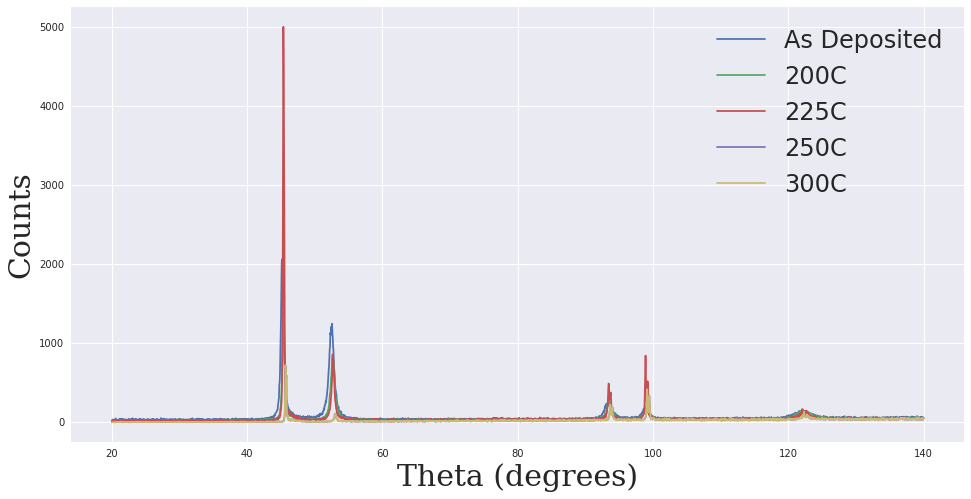

In [6]:
import matplotlib.font_manager as font_manager
axis_font = {'fontname':'DejaVu Serif', 'size':'30'}
font_prop = font_manager.FontProperties(size=24)
plt.figure(figsize=(16,8))
plt.plot(X_AD,Y_AD)
plt.plot(X_200,Y_200)
plt.plot(X_225,Y_225)
plt.plot(X_250,Y_250)
plt.plot(X_300,Y_300)
plt.xlabel('Theta (degrees)',**axis_font)
plt.ylabel('Counts',**axis_font)
plt.legend(['As Deposited','200C','225C','250C','300C'],prop=font_prop)
plt.savefig('XRD_initial.svg')

Since this is based on counting the number of occurrences of a phenomena, the noise is from a Poisson process.Thus, we fit a Poisson likelihood function using sparse variational inference.

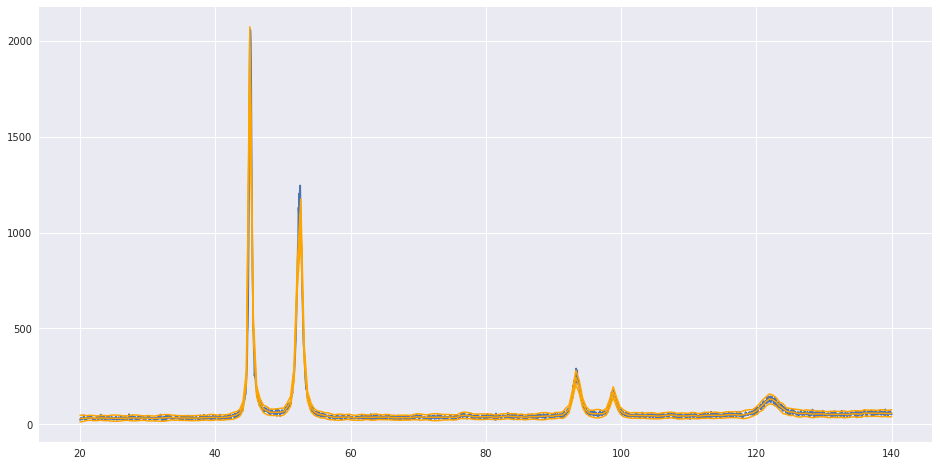

In [192]:
D = X_AD.shape[1]
radial_kernel = gpflow.kernels.RBF(D,1)
matern_kernel = gpflow.kernels.Matern12(D,1)
likelihood = gpflow.likelihoods.Poisson()
#Z = X_AD[:750].copy()
sampling = np.random.choice(range(len(X_AD)),size=500,p=(Y_AD.flatten()/np.sum(Y_AD)))
#m = gpflow.svgp.SVGP(X_AD, Y_AD, radial_kernel,likelihood=likelihood,Z=X_AD[sampling],minibatch_size=len(X_AD))
#m = gpflow.vgp.VGP(X_AD,Y_AD,radial_kernel,likelihood=likelihood)
m = gpflow.sgpmc.SGPMC(X_AD,Y_AD,matern_kernel,likelihood,Z=X_AD[sampling])
m.optimize()
#m.kern.variance.prior = gpflow.priors.Gamma(2,0.01)
pX = np.linspace(20, 140,num=240)[:, None]
pY, pYv = m.predict_y(pX)
plt.figure(figsize=(16,8))
plt.plot(X_AD,Y_AD)
line, = plt.plot(pX, pY, color='orange',lw=1.5)
plt.plot(pX, pY+2*pYv**0.5, color='orange', lw=1.5)
plt.plot(pX, pY-2*pYv**0.5, color='orange', lw=1.5)
#plt.plot(m.Z.value, np.zeros(m.Z.value.shape), 'k|', color='orange', mew=2)

Let's use affinity propogation to group our data.

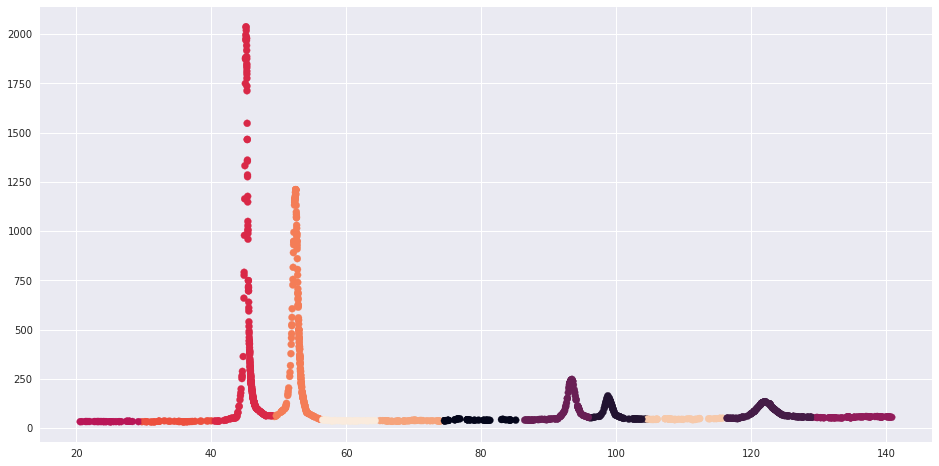

In [96]:
from sklearn.cluster import AffinityPropagation
    
sampling = np.random.choice(range(len(X_AD)),size=300,p=(Y_AD.flatten()/np.sum(Y_AD))) #sample by probability density
thetas = X_AD[approximate_maxima].flatten() + np.random.rand(len(approximate_maxima))
pY, pYv = m.predict_y(np.expand_dims(thetas,axis=-1))
affinity = AffinityPropagation(damping=0.95)
affinity.fit(np.expand_dims(thetas,axis=-1))
plt.figure(2,figsize=(16,8))
plt.scatter(thetas,pY,c=affinity.labels_/np.max(affinity.labels_))

Let's pick out a peak we know, and look at it more closely.

In [98]:
print(affinity.predict(42))

[6]


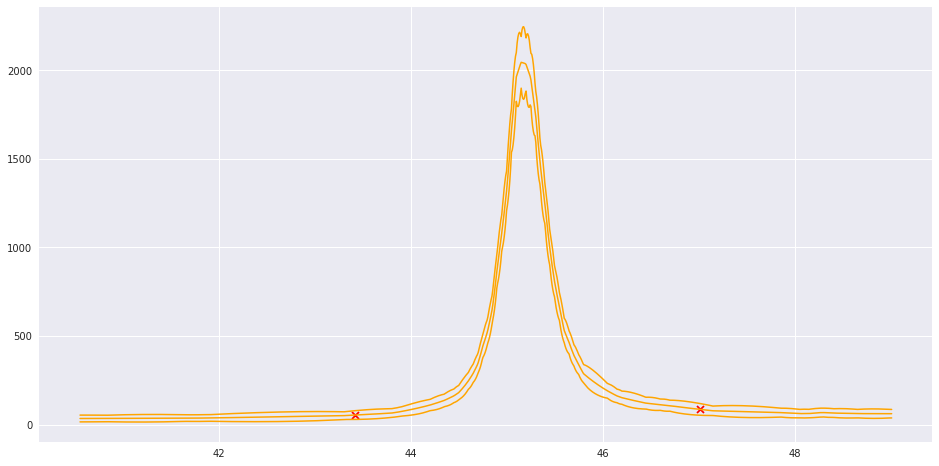

In [193]:
cluster = thetas[affinity.labels_ == 6]
min_theta,max_theta = np.min(cluster),np.max(cluster)
#let's densely sample points between min_theta and max_theta
search_theta = np.linspace(min_theta,max_theta,1000)
pY,pYv = m.predict_y(np.expand_dims(search_theta,axis=-1))
confidence = 3*pYv**0.5
plt.figure(3,figsize=(16,8))
plt.plot(search_theta, pY, color='orange',lw=1.5)
plt.plot(search_theta, pY+3*pYv**0.5, color='orange', lw=1.5)
plt.plot(search_theta, pY-3*pYv**0.5, color='orange', lw=1.5)

#moving forward from min_theta and moving backward from max_theta
#try to find a change in theta greater than 3 * the standard deviation, a 99.7% CI 
lower = np.min(np.where((pY>(pY[0]+confidence[0])))[0])
upper = np.max(np.where((pY>(pY[-1]+confidence[-1])))[0])
lower_theta = search_theta[lower]
upper_theta = search_theta[upper]
plt.scatter(lower_theta,pY[lower],marker='x',color='red')
plt.scatter(upper_theta,pY[upper],marker='x',color='red')

We now use the trapezoid rule to integrate the definite integral using the expectation values, and compute the variance.

$$\sigma^2[\int_l^uf(\theta)d\theta] \approx \sigma^2\sum_{k=1}^N\frac{f(\theta_{k-1})+f(\theta_k)}{2}\Delta\theta$$
$$\sigma^2[\int_l^uf(\theta)d\theta] \approx \frac{\Delta\theta^2}{4}\sum_{k=1}^N\sigma^2[f(\theta_{k-1}]+\sigma^2[f(\theta_k)]$$
$$\sigma^2[\int_l^uf(\theta)d\theta] \approx \frac{\Delta\theta^2}{4}\sum_{k=1}^N\sigma^2_{k-1}[f(\theta)]+\sigma^2_k[f(\theta)]$$

We then subtract the area of the right trapezoid underneath the peak, thus, increasing the variance to:

$$\sigma^2(\text{Peak Area}) =\sigma^2[\int_l^uf(\theta)d\theta]+\sigma^2[\text{min}(\theta)]\Delta^2 + \frac{\text{max}\theta-\text{min}\theta}{4}(\sigma^2[\text{min}(\theta)]+\sigma^2[\text{max}(\theta)])$$

Finally, we divide this area by the maximum to get the peak breadth $\beta$. We find the upper bound of the variance by not subtracting the covariance of the area and the maximum (I'll work out the math for a Guassian peak, just not right now). 

$$\sigma^2(\beta)<\frac{\textbf{E}(\text{Peak Area})^2}{\textbf{E}[\text{max}(\theta)]^2}(\frac{(\sigma^2(\text{Peak Area}))^2}{\textbf{E}(\text{Peak Area})}+\frac{(\sigma^2[\text{max}(\theta)])^2}{\textbf{E}(\text{Maximum})})$$

In [200]:
search_theta = np.linspace(lower_theta,upper_theta,1000)
pY,pYv = m.predict_y(np.expand_dims(search_theta,axis=-1))
pY,pYv = pY.flatten(),pYv.flatten()
integral = np.trapz(pY,dx=(delta/1000))

bounds = np.array([pYv[0],pYv[1]])
delta = (upper_theta-lower_theta)
variance = np.trapz(pYv,dx=(delta/1000))*(delta/1000)**2/4

integral -= delta*min(bounds) + delta*abs(pY[0]-pY[-1])/2
variance += (min(bounds)*(delta**2) + (pYv[0]+pYv[-1])*(delta**2)/4)
variance = integral**2/(np.max(pY)**2) * (variance/(integral**2) + pYv[np.argmax(pY)]/(np.max(pY)**2))
    
#variance is actually a bit smaller, since we should be subtracting the covariance of the width and the area
    
print('Width: {} Standard Deviation: {}'.format(width,variance**0.5))

Width: 0.586738501191982 Standard Deviation: 0.023599126255527486


Computing the crystallite size by the Scherrer equation is easy, since we have $\beta$. We can estimate a confidence bound using $\sigma^2(\beta)$, since the variance of $\tau=\frac{K\lambda}{\beta\text{cos}\theta}$ is undefined (sinc the integral of $\frac{1}{\beta}$ converges. We can check to see if the variance is computable with the denominator evaluated with respect to $\theta$, but it's not guaranteed.

In [210]:
tau = 0.15418/(width*(np.pi/180)*np.cos(search_theta[np.argmax(pY)]*(np.pi/180)))
CI = (0.15418/((width+variance**0.5)*(np.pi/180)*np.cos(search_theta[np.argmax(pY)]*(np.pi/180))),\
      0.15418/((width-variance**0.5)*(np.pi/180)*np.cos(search_theta[np.argmax(pY)]*(np.pi/180))))
print('Crystallite Size is between {}'.format(CI))

Crystallite Size is between (20.523472292631567, 22.24360068496885)
